# Face Emotion Recognition

# Import Library

In [1]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from keras.layers import Conv2D, Dense, BatchNormalization, Activation, Dropout, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from keras import regularizers
from keras.callbacks import ModelCheckpoint, CSVLogger, TensorBoard, EarlyStopping, ReduceLROnPlateau
import datetime
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Check GPU

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Import dataset

In [4]:
train_dir = "/kaggle/input/happy-sad-7125/train/"
test_dir = "/kaggle/input/happy-sad-7125/test/"

row, col = 48, 48
classes = 2

def count_exp(path, set_):
    dict_ = {}
    for expression in os.listdir(path):
        dir_ = path + expression
        dict_[expression] = len(os.listdir(dir_))
    df = pd.DataFrame(dict_, index=[set_])
    return df
train_count = count_exp(train_dir, 'train')
test_count = count_exp(test_dir, 'test')
print(train_count)
print(test_count)

        sad  happy
train  7215   7215
       sad  happy
test  1247   1247


<AxesSubplot: >

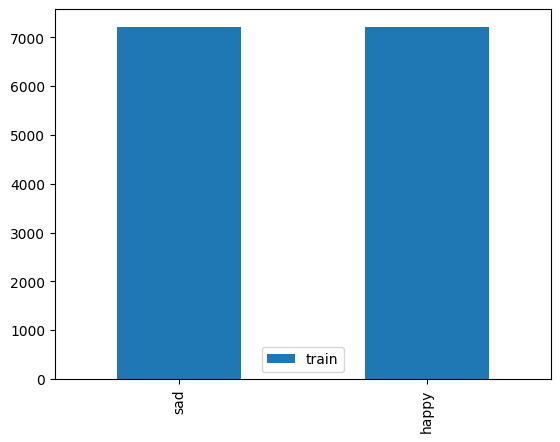

In [5]:
train_count.transpose().plot(kind='bar')

<AxesSubplot: >

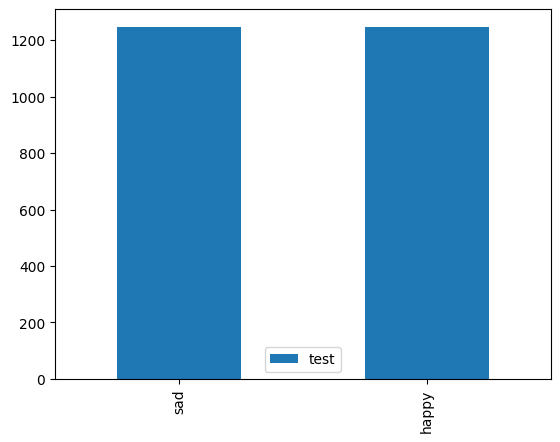

In [6]:
test_count.transpose().plot(kind='bar')

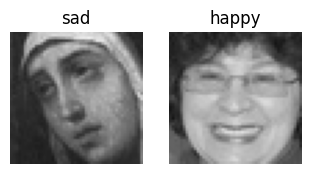

In [7]:
plt.figure(figsize=(14,22))
i = 1
for expression in os.listdir(train_dir):
    img = load_img((train_dir + expression +'/'+ os.listdir(train_dir + expression)[1]))
    plt.subplot(1,7,i)
    plt.imshow(img)
    plt.title(expression)
    plt.axis('off')
    i += 1
plt.show()

# Augmentation

In [8]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   zoom_range=0.4,
                                   horizontal_flip=True)

training_set = train_datagen.flow_from_directory(train_dir,
                                                batch_size=16,
                                                target_size=(48,48),
                                                shuffle=True,
                                                color_mode='grayscale',
                                                class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1./255)
test_set = test_datagen.flow_from_directory(test_dir,
                                                batch_size=15,
                                                target_size=(48,48),
                                                shuffle=True,
                                                color_mode='grayscale',
                                                class_mode='categorical')

Found 14430 images belonging to 2 classes.
Found 2494 images belonging to 2 classes.


In [9]:
training_set.class_indices

{'happy': 0, 'sad': 1}

# Creating model

In [10]:
def get_model(input_size, classes=2):
     #Initialising the CNN
    model = tf.keras.models.Sequential()   

    model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape =input_size))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2, 2))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)))
    model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(2, activation='softmax'))

    #Compliling the model
    model.compile(optimizer=Adam(learning_rate=0.0001), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    return model

In [11]:
print(classes)

2


In [12]:
model_3 = get_model((row,col,1), classes)
model_3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        18496     
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 128)       7

# Callback

In [13]:
chk_path = 'model_3.h5'
log_dir = "checkpoint/logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

checkpoint = ModelCheckpoint(filepath=chk_path,
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             moniter='val_loss')

earlystop = EarlyStopping(monitor='val_loss', 
                          min_delta=0, 
                          patience=3, 
                          verbose=1, 
                          restore_best_weights=True)
                        
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.2, 
                              patience=6, 
                              verbose=1, 
                              min_delta=0.0001)


tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
csv_logger = CSVLogger('training.log')

callbacks = [checkpoint, reduce_lr, csv_logger]

In [16]:
steps_per_epoch = training_set.n // training_set.batch_size
validation_steps = test_set.n // test_set.batch_size

hist = model_3.fit(x=training_set,
                 validation_data=test_set,
                 epochs=60,
                 callbacks=callbacks,
                 steps_per_epoch=steps_per_epoch,
                 validation_steps=validation_steps)

Epoch 1/60
899/901 [============================>.] - ETA: 0s - loss: 1.0948 - accuracy: 0.7171
Epoch 1: val_loss improved from 1.67702 to 0.95703, saving model to model_3.h5
901/901 [==============================] - 24s 27ms/step - loss: 1.0945 - accuracy: 0.7173 - val_loss: 0.9570 - val_accuracy: 0.7333 - lr: 1.0000e-04
Epoch 2/60
899/901 [============================>.] - ETA: 0s - loss: 0.8370 - accuracy: 0.7500
Epoch 2: val_loss improved from 0.95703 to 0.66779, saving model to model_3.h5
901/901 [==============================] - 24s 27ms/step - loss: 0.8371 - accuracy: 0.7500 - val_loss: 0.6678 - val_accuracy: 0.8161 - lr: 1.0000e-04
Epoch 3/60
901/901 [==============================] - ETA: 0s - loss: 0.6717 - accuracy: 0.7833
Epoch 3: val_loss did not improve from 0.66779
901/901 [==============================] - 23s 26ms/step - loss: 0.6717 - accuracy: 0.7833 - val_loss: 0.7220 - val_accuracy: 0.7602 - lr: 1.0000e-04
Epoch 4/60
899/901 [============================>.] - ETA

### acc: 0.95
### val_acc: 0.92

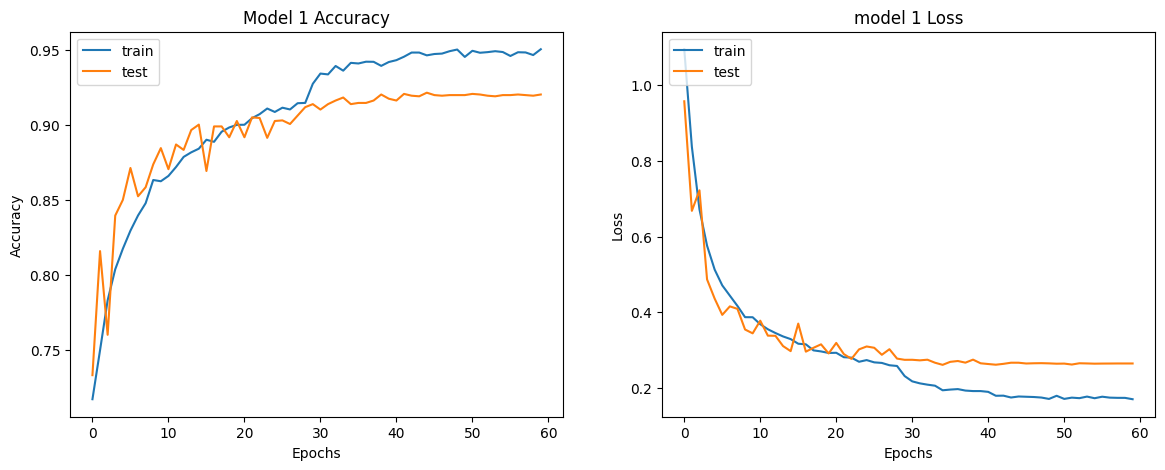

In [17]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model 1 Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(1,2,2)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model 1 Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Model Evaluation

In [18]:
train_loss, train_accu = model_3.evaluate(training_set)
test_loss, test_accu = model_3.evaluate(test_set)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

167/167 [==============================] - 3s 15ms/step - loss: 0.2645 - accuracy: 0.9206
final train accuracy = 96.58 , validation accuracy = 92.06


In [19]:
model_3.save_weights('model_3_best_weights.h5')

In [20]:
model_3.save('model_3.h5')